In [12]:
import numpy as np
from tqdm.auto import tqdm
import time, json, sys, os
import matplotlib.pyplot as plt
import mnist_loader

trained_model_file = './TrainedModelData.sav'

In [13]:
class SGD():
	"""
	SGD (short for Stochastic Gradient Descent), represents an optimization algorithm 
	that can be used to train a neural network model.
	The __call__ method of the SGD class performs a single iteration of training, 
	which includes iterating over the training data in mini-batches, 
	making predictions using the forward propagation method, and updating the model's weights and biases 
	using the back-propagation method. 
	The forward_propagation and back_propagation methods are helper methods that implement the 
	forward and backward passes of the training algorithm, respectively. 
	The SGD class is initialized with a reference to the MLP model that it will be optimizing.
	"""
	def __init__( self, model = None ):
		self.model         = model
		self.learning_rate = model.learning_rate
		self.lmbda         = model.lmbda
		self.loss          = model.loss
		self.activation    = model.activation
		self.num_layers    = model.num_layers

	def __call__( self, batch, num_data ):
		nabla_W = [ np.zeros( w.shape ) for w in self.model.weights ]
		nabla_B = [ np.zeros( b.shape ) for b in self.model.biases ]

		"""
		This loop calculates the gradient of loss with respect to all variables, 
		sums them up and stores in nabla_Wm nabla_B lists,
		"""
		for inputs, labels in batch:
			a  = inputs 	# Activation
			As = [inputs] 	# list to store all the Activation matrix, layer by layer
			Zs = []			# list to store all the z vectors, layer by layer

			self.forward_propagation( a, As, Zs )
			delta_Nabla_W, delta_Nabla_B = self.back_propagation(As, Zs, labels)

			# Summing up all the changes in weights amd biases
			nabla_W = [ nw + d_nw for nw, d_nw in zip( nabla_W, delta_Nabla_W ) ]
			nabla_B = [ nb + d_nb for nb, d_nb in zip( nabla_B, delta_Nabla_B ) ]

		# Taking steps towards the lowest loss function
		# lmbda, regularization parameter
		regularization  = 1 - ( self.learning_rate * ( self.lmbda / num_data ) )
		nw_coef = self.learning_rate / len(batch)

		self.model.weights = [
			( regularization * w ) - ( nw_coef * nw )
			for w, nw in zip( self.model.weights, nabla_W )
		]

		self.model.biases = [ 
			b - ( self.learning_rate / len(batch) ) * nb
			for b, nb in zip( self.model.biases, nabla_B ) 
		]
	
	def forward_propagation( self, a, As=None, Zs=None  ):
		"""
		This code defines a forward_propagation algorithm. 
		It is called during the training of out neural network.

		The method takes three arguments:

		a  : a matrix of input activations
		As : a list to store the activation matrices, layer by layer
		Zs : a list to store the z vectors, layer by layer

		The method uses the weights and biases of the model to perform a 
		forward propagation through the network. 
		This means that the input activations "a" are passed through the network layer by layer, 
		and the output activations are returned by the method.

		In addition to returning the output activations, 
		the method also appends the intermediate activation matrices 
		and z vectors to the As and Zs lists if they are provided. 
		These lists will be used later in the back-propagation step of training.
		"""
		for W, b in zip( self.model.weights, self.model.biases ):
			z = np.dot( W, a ) + b
			if Zs != None : Zs.append(z)

			a = self.activation(z)
			if As != None : As.append(a)
		return a
	
	def back_propagation( self, As, Zs, labels ):
		"""
		This function is implementing back-propagation, a method for training a neural network. 
		The back-propagation algorithm is used to calculate the gradient of the loss function with respect to 
		the weights and biases of the network. This is used to update the weights and biases to reduce the loss 
		and improve the performance of the network on a given task.

		It takes three arguments: 
		As		 : a list to store the activation matrices, layer by layer
		Zs		 : a list to store the z vectors, layer by layer , where z = (a * w) + b
		labels : a numpy array of target values for the network.

		First the method initializes two lists, nabla_W and nabla_B, to store the gradients of the loss function 
		with respect to the weights and biases of the network, respectively. 
		These are initialized to be arrays of zeros with the same shape as the weight and bias arrays of the network.

		Next, it calculates the gradient of the loss with respect to the output of the network, 
		and stores the result in delta_error. It then uses this to calculate the gradient of the loss with respect to 
		the final layer's weights and biases, and stores these in nabla_W and nabla_B, respectively.

		It then loops through the layers of the network in reverse order (from the second-to-last layer to the first layer), 
		and uses the previously calculated gradients to compute the gradients of the loss with respect to the weights and biases 
		of each layer.

		Finally, the method returns the calculated gradients in nabla_W and nabla_B.
		"""
		nabla_W = [ np.zeros( w.shape ) for w in self.model.weights ]
		nabla_B = [ np.zeros( b.shape ) for b in self.model.biases ]

		delta_error = self.loss.delta( As[-1], labels )
		nabla_W[-1] = np.dot( delta_error, As[-2].transpose() )
		nabla_B[-1] = delta_error
	
		# Backwards pass / Back-propagation
		for l in range(2, self.num_layers):
			delta_error = np.dot( self.model.weights[-l + 1].transpose(), delta_error ) * self.activation.prime( Zs[-l] )
			nabla_W[-l] = np.dot( delta_error, As[-l - 1].transpose() )
			nabla_B[-l] = delta_error

		return nabla_W, nabla_B

In [14]:
	def forward_propagation( self, a, As=None, Zs=None  ):
		"""
		This code defines a forward_propagation algorithm. 
		It is called during the training of out neural network.

		The method takes three arguments:

		a  : a matrix of input activations
		As : a list to store the activation matrices, layer by layer
		Zs : a list to store the z vectors, layer by layer

		The method uses the weights and biases of the model to perform a 
		forward propagation through the network. 
		This means that the input activations "a" are passed through the network layer by layer, 
		and the output activations are returned by the method.

		In addition to returning the output activations, 
		the method also appends the intermediate activation matrices 
		and z vectors to the As and Zs lists if they are provided. 
		These lists will be used later in the back-propagation step of training.
		"""
		for W, b in zip( self.model.weights, self.model.biases ):
			z = np.dot( W, a ) + b
			if Zs != None : Zs.append(z)

			a = self.activation(z)
			if As != None : As.append(a)
		return a
	
	def back_propagation( self, As, Zs, labels ):
		"""
		This function is implementing back-propagation, a method for training a neural network. 
		The back-propagation algorithm is used to calculate the gradient of the loss function with respect to 
		the weights and biases of the network. This is used to update the weights and biases to reduce the loss 
		and improve the performance of the network on a given task.

		It takes three arguments: 
		As		 : a list to store the activation matrices, layer by layer
		Zs		 : a list to store the z vectors, layer by layer , where z = (a * w) + b
		labels : a numpy array of target values for the network.

		First the method initializes two lists, nabla_W and nabla_B, to store the gradients of the loss function 
		with respect to the weights and biases of the network, respectively. 
		These are initialized to be arrays of zeros with the same shape as the weight and bias arrays of the network.

		Next, it calculates the gradient of the loss with respect to the output of the network, 
		and stores the result in delta_error. It then uses this to calculate the gradient of the loss with respect to 
		the final layer's weights and biases, and stores these in nabla_W and nabla_B, respectively.

		It then loops through the layers of the network in reverse order (from the second-to-last layer to the first layer), 
		and uses the previously calculated gradients to compute the gradients of the loss with respect to the weights and biases 
		of each layer.

		Finally, the method returns the calculated gradients in nabla_W and nabla_B.
		"""
		nabla_W = [ np.zeros( w.shape ) for w in self.model.weights ]
		nabla_B = [ np.zeros( b.shape ) for b in self.model.biases ]

		delta_error = self.loss.delta( As[-1], labels )
		nabla_W[-1] = np.dot( delta_error, As[-2].transpose() )
		nabla_B[-1] = delta_error
	
		# Backwards pass / Back-propagation
		for l in range(2, self.num_layers):
			delta_error = np.dot( self.model.weights[-l + 1].transpose(), delta_error ) * self.activation.prime( Zs[-l] )
			nabla_W[-l] = np.dot( delta_error, As[-l - 1].transpose() )
			nabla_B[-l] = delta_error

		return nabla_W, nabla_B

In [15]:
class CrossEntropyLoss():
	"""
	CrossEntropyLoss implements the cross-entropy loss function for a binary classification task.
	It measures the difference between the predicted probability distribution over classes and 
	the true probability distribution over classes.
	"""
	@staticmethod
	def func(a, y):
		"""
		The func method takes two arguments, a and y, and calculates the cross-entropy loss for a given prediction a 
		and true label y. This is done by summing the cross-entropy loss for each example in the batch of data.
		"""
		return np.sum( np.nan_to_num( -y * np.log(a) - (1-y) * np.log(1-a) ) )

	@staticmethod
	def delta(a, y):
		"""
		The delta method calculates the gradient of the cross-entropy loss with respect to the output of the network. 
		It simply returns the difference between the predicted probabilities (a) and the true labels (y). 
		This is used in the back-propagation algorithm to calculate the gradient of the loss with respect to the 
		weights and biases of the network.
		"""
		return ( a - y )

In [16]:
class Sigmoid():
	"""
	The sigmoid function is often used as the activation function for neurons in a neural network. 
	It maps a real-valued input to a value between 0 and 1, which can be interpreted as a probability.
	"""
	def __call__( self, z ):
		"""
		This method is called when an instance of the class is called as a function, 
		and it calculates the sigmoid function for the given input z.
		"""
		return 1.0 / ( 1.0 + np.exp(-z) )

	def prime( self, z ):
		"""
		The prime method calculates the derivative of the sigmoid function for the given input z. 
		This is used in the back-propagation algorithm to calculate the gradient of the loss with respect to the inputs to each neuron in the network.
		"""
		return self( z ) * ( 1.0 - self( z ) )

In [17]:
class MLP( object ):
	"""
	A basic Multi-Layers Perceptron model, which represents a basic neural network model. 
	The class constructor ( __init__ ) takes several parameters that specify the model's configuration, 
	such as the number of layers in the network, the type of optimizer and loss function to use, and the learning rate. 
	The fit method trains the model on a given dataset, while the predict method uses the trained model 
	to make inference on new data.
	The MLP class also includes several helper methods such as __make_batches which divides the training data 
	into batches, and __load_variables which loads previously saved weights and biases for the model.
	"""
	def __init__( 
			self,
			layers        = [784,30,10],
			optimizer     = SGD,
			loss          = CrossEntropyLoss,
			activation    = Sigmoid,
			learning_rate = 0.1,
			lmbda         = 5.0,
		):
		self.num_layers    = len(layers)
		self.layers        = layers
		self.loss          = loss()
		self.activation    = activation()
		self.learning_rate = learning_rate
		self.lmbda         = lmbda
		self.optimizer     = optimizer( model=self )
		self.weights       = [ 
			np.random.randn(y, x) / np.sqrt(x)
			for x, y in zip( layers[:-1], layers[1:] )
		]
		self.biases	= [ np.random.randn(y, 1) for y in layers[1:] ]
		self.is_last_epoch = False
		self.num_train_data = 0
		self.epoch_start_time = 0
	
	def fit(
			self, 
			train_data     = None,
			val_data       = None,
			epochs         = 10,
			batch_size     = 32,
			continue_train = False,
			monitor        = None
		):
		self.num_train_data = len( train_data )

		if ( continue_train ):
			self.__load_viriables()
	
		epochs_progress_bar = tqdm( range(epochs), ncols=85, position=0 )
		for epoch in epochs_progress_bar:
			"""
			This is the training loop for our neural network. 
			It iterates through a number of epochs (passes over the training data) and within each epoch, 
			it splits the training data into batches and trains the model on each batch using the specified optimizer.
			For each epoch, it also calls the monitor function to record the training and validation metrics.
			The epochs_progress_bar and batches_progress_bar are using the tqdm library to show progress bars for the training loop.
			"""
			self.epoch_start_time   = time.time()
			self.is_last_epoch = True if epoch+1 == epochs else False
			epochs_progress_bar.set_description( f'Epoch {epoch+1}' )
			batches = self.__make_batches( train_data, batch_size )

			batches_progress_bar = tqdm(batches, desc=f'Batch', ncols=75, position=1, ascii=False, leave=False)
			for batch in batches_progress_bar:
				self.optimizer( batch, self.num_train_data )

			if ( monitor != None ):
				monitor( self, epoch, self.epoch_start_time, self.num_train_data, train_data, val_data )
			
	def __load_viriables(self):
		with open(trained_model_file, "r") as f:
			data = json.load(f)
		self.weights = [np.array(w) for w in data["weights"]]
		self.biases  = [np.array(b) for b in data["biases"]]
		print( "Last saved, Hidden neurons: ", len( self.weights[0] ), ", ", data["accuracy"] )
	
	def __make_batches( self, data, batch_size ):
		np.random.shuffle( data )
		# Creating batches out of training data
		batches = [
			data[ k : k + batch_size ]
			for k in range( 0, self.num_train_data, batch_size )
		]
		return batches

	def predict(self, x):
		a = self.optimizer.forward_propagation( x )
		return ( np.argmax(a) )

In [18]:
class Monitor():
	"""
	This class monitors the performance of the model. 
	It has attributes for tracking whether training and validation data should be monitored, 
	as well as whether the current model parameters should be saved if they yield the best performance so far. 
	The Monitor class also has methods for computing the total loss and accuracy on a given dataset, 
	and for printing the current values of these metrics. 
	When the __call__ method of the Monitor instance is invoked, it updates the relevant metrics and prints them.
	"""
	def __init__( self, training=False, validation=True, save=False ):
		self.training   = training
		self.validation = validation
		self.save       = save

		self.evaluation_loss, self.evaluation_accuracy = [], []
		self.training_loss, self.training_accuracy = [], []
		self.maxAccuracy = 0;
		self.max_w       = []
		self.max_b       = []
		self.train_loss, self.train_accuracy, self.val_loss, self.val_accuracy = 0,0,0,0
	
	def __call__( self, model, epoch, epoch_start_time, num_train_data, train_data, val_data ):
		self.model = model
		self.is_val_data = val_data != None
		
		if self.training:
			self.train_loss = self.total_loss(train_data)
			self.training_loss.append(self.train_loss)
	
			self.train_accuracy = self.accuracy(train_data, convert=True)
			self.training_accuracy.append(self.train_accuracy)

		if self.is_val_data & self.validation:
			self.num_val_data = len( val_data )
			self.val_loss = self.total_loss(val_data, convert=True)
			self.evaluation_loss.append(self.val_loss)

			self.val_accuracy = self.accuracy(val_data)
			self.evaluation_accuracy.append(self.val_accuracy)
		
		self.print_metrics( epoch, epoch_start_time, num_train_data )

	def print_metrics( self, epoch, epoch_start_time, num_train_data ):
		"""
		Prints the relevant training metrics to the console.
		"""
		loss       = round( self.train_loss, 2 ) if self.training  else 0
		accuracy   = round( ( self.train_accuracy/num_train_data ), 2 ) if self.training  else 0
		v_loss     = round( self.val_loss, 2 ) if self.is_val_data & self.validation  else 0
		v_accuracy = round( ( self.val_accuracy/self.num_val_data ), 2 ) if self.is_val_data & self.validation  else 0
		epoch_time = str( round( time.time() - epoch_start_time, 2 ) ) + "s"
		if self.training & self.is_val_data & self.validation:
			tqdm.write( 
				f'{str(epoch+1):3s}: {"loss"}: {str(loss):4s} — {"accuracy"}: {str(accuracy):4s} — {"val_loss"}: {str(v_loss):4s} — {"val_accuracy"}: {str(v_accuracy):4s} — {epoch_time}' 
			)
			
		elif self.training & ( (self.is_val_data == False) or (self.validation == False) ):
			tqdm.write( 
				f'{str(epoch+1):3s}: {"loss"}: {str(loss):4s} — {"accuracy"}: {str(accuracy):4s} — {epoch_time}' 
			)

		elif self.is_val_data & self.validation & (self.training == False):
			tqdm.write( 
				f'{str(epoch+1):3s}: {"val_loss"}: {str(v_loss):4s} — {"val_accuracy"}: {str(v_accuracy):4s} — {epoch_time}' 
			)

		if ( self.val_accuracy > self.maxAccuracy ):
			self.maxAccuracy = self.val_accuracy
			self.max_w, self.max_b = self.model.weights, self.model.biases

		if ( self.save ): 
			self.save_model()
			if ( self.model.is_last_epoch ):
				self.model.weights, self.model.biases = self.max_w, self.max_b
				self.save_model()

	def save_model( self ):
		"""
		Saves the model variables.
		"""
		data = {
			"layers"       : self.model.layers,
			"weights"      : [ w.tolist() for w in self.model.weights ],
			"biases"       : [ b.tolist() for b in self.model.biases ],
			"optimizer"    : str( self.model.optimizer.__class__.__name__ ),
			"loss"         : str( self.model.loss.__class__.__name__ ),
			"activation"   : str( self.model.activation.__class__.__name__ ),
			"learning_rate": self.model.learning_rate,
			"lmbda"        : self.model.lmbda,
			"accuracy"     : self.maxAccuracy,
		}
		with open(trained_model_file, "w") as f:
			json.dump(data, f)

	def history(self):
		return self.evaluation_loss, self.evaluation_accuracy, \
			self.training_loss, self.training_accuracy

	def accuracy(self, data, convert=False):
		"""
		The accuracy method takes a list of data as input, where each data point consists of input values and 
		corresponding labels. The convert parameter determines whether the labels in the data should be converted 
		to their index in the label vector (for example, the label vector [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 
		would be converted to 2). 
		The method computes the accuracy of the model's predictions on the input data by comparing the 
		model's predicted label with the true label for each data point. The predicted labels are obtained by 
		using the model's forward_propagation method on the input values. 
		The method returns the percentage of correct predictions.
		"""
		results = [
			( np.argmax( self.model.optimizer.forward_propagation( x ) ), np.argmax( y ) )
			for x, y in tqdm( data, desc="Accuracy", ncols=75, leave=False, position=1 )
		] if convert else [
			( np.argmax( self.model.optimizer.forward_propagation( x ) ), y )
			for x, y in tqdm( data, desc="Accuracy", ncols=75, leave=False, position=1 )
		]
		return sum( int( x == y ) for ( x, y ) in results )

	def total_loss(self, data, convert=False):
		"""
		This method calculates the average loss across all the examples in the dataset.
		It also includes a regularization term (lambda) to penalize large weights.
		"""
		loss = 0.0
		for x, y in tqdm(data, desc="Cost", ncols=75, leave=False, position=1):
			a = self.model.optimizer.forward_propagation(x)
			y = vectorized_result(y) if convert else y
			loss += self.model.loss.func(a, y)/len(data)

		loss += 0.5*( self.model.optimizer.lmbda / len( data ) ) * \
			sum( np.linalg.norm(w)**2 for w in self.model.weights )
		return loss

In [19]:
def load_model():
	"""
	Returns a trained model.
	"""
	with open(trained_model_file, "r") as f:
		data = json.load(f)

	optimizer  = getattr(sys.modules[__name__], data["optimizer"])
	loss       = getattr(sys.modules[__name__], data["loss"])
	activation = getattr(sys.modules[__name__], data["activation"])
	model      = MLP( 
		data["layers"],
		optimizer     = optimizer,
		loss          = loss,
		activation    = activation,
		learning_rate = data["learning_rate"],
		lmbda         = data["lmbda"],
	)

	model.weights = [np.array(w) for w in data["weights"]]
	model.biases  = [np.array(b) for b in data["biases"]]
	return model

def model_accuracy():
	"""
	Returns the trained model accuracy.
	"""
	with open(trained_model_file, "r") as f:
		data = json.load(f)
	return data["accuracy"]

def vectorized_result(j):
	e = np.zeros((10, 1))
	e[j] = 1.0
	return e

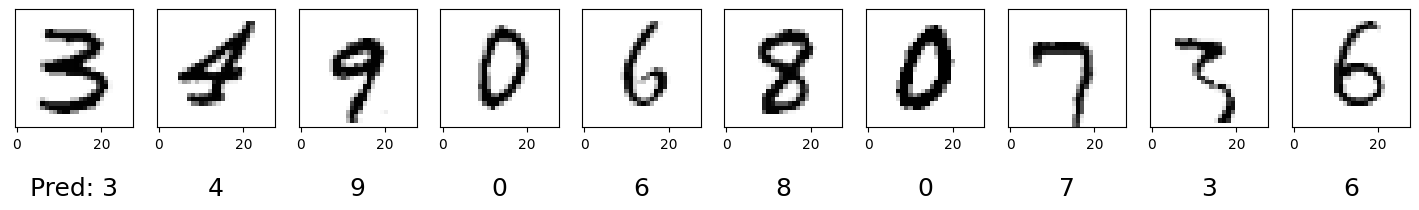

In [21]:
train_data, val_data = mnist_loader.load_data_wrapper() # Loading the MNIST data.

"""
Creating a Multi-Layer Perceptron (MLP) model with 784 input units, 30 hidden units, and 10 output units.
The optimizer used is Stochastic Gradient Descent (SGD), the loss function is Cross-Entropy Loss, and the activation function is Sigmoid.
The learning rate is set to 0.1 and the regularization parameter (lmbda) is set to 5.0.
"""
model = MLP( 
    layers        = [ 784, 30, 10 ],
    optimizer     = SGD,
    loss          = CrossEntropyLoss,
    activation    = Sigmoid,
    learning_rate = 0.1,
    lmbda         = 5.0,
)

# Monitors the relevant model metrics while training.
monitor = Monitor(
    training   = True,
    validation = True,
    save       = False,
)

"""
Train the model and store the training history in the evaluation_cost, 
evaluation_accuracy, training_cost, and training_accuracy lists.
"""
if 0:
  model.fit(
    train_data     = train_data[:10000],
    val_data       = val_data[:1000],
    epochs         = 5,
    batch_size     = 32,
    continue_train = True, # Loads the previously saved model data and overrides the model architecture.
    monitor        = monitor
  )
  evaluation_cost, evaluation_accuracy, \
  training_cost, training_accuracy = monitor.history()

# Loading the previously saved model.
model   = load_model()

"""
Number of data use for prediction from the validation data, we've not show the 
validation data to the model while training so it's ok to use it for prediction.
"""
n_preds = 10 
np.random.shuffle(val_data) # Shuffling the data to get diffrent elements every time.

# Plotting the images and predictions in a figure.
fig, axes = plt.subplots(1,n_preds, figsize=(18,18))

for i,ax in enumerate(axes.flat):
  ax.imshow( np.reshape(val_data[i][0], (28,28)), cmap="Greys" )
  ax.get_yaxis().set_visible(False)

  prediciton = 'Pred: ' + str( model.predict( val_data[i][0] ) ) if i==0 else str( model.predict( val_data[i][0] ) )
  ax.set_xlabel( prediciton, labelpad=18, size=18 )